In [18]:
# Basics: imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.kernel_ridge import KernelRidge
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import seaborn as sns
%matplotlib inline
sns.set_style('whitegrid')
import matplotlib as mpl

# === フォント設定 ===
mpl.rcParams['font.family'] = 'Arial'  # フォントをArialに指定
mpl.rcParams['font.size'] = 12         # 文字サイズ（任意）
mpl.rcParams['axes.linewidth'] = 1.2  # 枠線の太さ


### データ準備

In [2]:
# === 1. データ読み込み ===
df = pd.read_csv("Dataset_Simulated_Price_swaption.csv")
df['Date'] = pd.to_datetime(df['Date'], errors='coerce')
df = df.set_index('Date').sort_index()

# ---------- スケーラ / PCA / ウィンドウ ----------
def fit_scaler(X_all: np.ndarray, cut_train_end: int):
    scaler = StandardScaler().fit(X_all[:cut_train_end])
    X_scaled_all = scaler.transform(X_all)
    return scaler, X_scaled_all


# === 2. 列名から tenor / maturity を抽出 ===
import re
tenor_maturity = []
for col in df.columns:
    m = re.search(r'Tenor\s*:\s*(\d+).*?Maturity\s*:\s*([\d.]+)', col)
    if m:
        tenor = float(m.group(1))
        maturity = float(m.group(2))
        tenor_maturity.append((col, tenor, maturity))
    else:
        # データ形式が "Tenor1_Maturity0.0833" のような場合はこちら
        m = re.search(r'Tenor(\d+)_Maturity([\d.]+)', col)
        if m:
            tenor = float(m.group(1))
            maturity = float(m.group(2))
            tenor_maturity.append((col, tenor, maturity))

# === 3. 時系列特徴量を作成 ===
lags = 20
rows = []

for col, tenor, maturity in tenor_maturity:
    series = pd.to_numeric(df[col], errors='coerce').dropna()
    data = pd.DataFrame({'y': series})
    for i in range(1, lags + 1):
        data[f'lag_{i}'] = series.shift(i)
    data['tenor'] = tenor
    data['maturity'] = maturity
    data = data.dropna()
    rows.append(data)

# 全系列を結合
all_data = pd.concat(rows)

# === 4. 訓練データとテストデータ（日付インデックス基準） ===
# 日付でソート
all_data = all_data.sort_index()

# 8割の位置の日付を取得
split_date = all_data.index[int(len(all_data) * 0.8)]

# 日付を基準にデータを分割
train = all_data[all_data.index <= split_date]
test = all_data[all_data.index > split_date]

# 特徴量と目的変数を分割
X_train = train.drop('y', axis=1)
X_train_tnr_1_0_mtr_0_0833 = X_train[
    (X_train["tenor"] == 1.0) &
    (X_train["maturity"].sub(0.0833333333333333).abs() < 1e-6)
]
y_train = train['y']
y_train_tnr_1_0_mtr_0_0833 = y_train[
    (X_train["tenor"] == 1.0) &
    (X_train["maturity"].sub(0.0833333333333333).abs() < 1e-6)
]
X_test = test.drop('y', axis=1)
X_test_tnr_1_0_mtr_0_0833 = X_test[
    (X_test["tenor"] == 1.0) &
    (X_test["maturity"].sub(0.0833333333333333).abs() < 1e-6)
]
y_test = test['y']
y_test_tnr_1_0_mtr_0_0833 = y_test[
    (X_test["tenor"] == 1.0) &
    (X_test["maturity"].sub(0.0833333333333333).abs() < 1e-6)
]

print(f"📆 Split date: {split_date}")
print(f"✅ Train size: {len(train)}, Test size: {len(test)}")

# ==== スケーリングとPCA による次元圧縮 ====
# スケーリング
scaler_x = MinMaxScaler()
scaler_y = MinMaxScaler()

# 特徴量のスケーリング
X = np.vstack([X_train_tnr_1_0_mtr_0_0833, X_test_tnr_1_0_mtr_0_0833])
X_scaled = scaler_x.fit_transform(X)
X_train_scaled = X_scaled[:len(X_train_tnr_1_0_mtr_0_0833)]
X_test_scaled = X_scaled[len(X_train_tnr_1_0_mtr_0_0833):]

# 目的変数のスケーリング
y = np.hstack([y_train_tnr_1_0_mtr_0_0833, y_test_tnr_1_0_mtr_0_0833])
y_scaled = scaler_y.fit_transform(y.reshape(-1, 1)).flatten()
y_train_scaled = y_scaled[:len(y_train_tnr_1_0_mtr_0_0833)]
y_test_scaled = y_scaled[len(y_train_tnr_1_0_mtr_0_0833):]

# PCAによる次元圧縮（6量子ビット → 64次元）
n_components = 6  # 2^6
pca = PCA(n_components=n_components)
X_pca = pca.fit_transform(X_scaled)

# 圧縮されたデータを訓練・テストに分割
X_train_pca = X_pca[:len(X_train_tnr_1_0_mtr_0_0833)]
X_test_pca = X_pca[len(X_train_tnr_1_0_mtr_0_0833):]

print(f"Original feature dimensions: {X_scaled.shape[1]}")
print(f"Compressed feature dimensions: {X_pca.shape[1]}")
print(f"Explained variance ratio: {pca.explained_variance_ratio_.sum():.4f}")

# 訓練データとテストデータの設定
X_train, X_test = X_train_pca, X_test_pca
y_train, y_test = y_train_scaled, y_test_scaled

📆 Split date: 2051-08-15 00:00:00
✅ Train size: 86240, Test size: 21280
Original feature dimensions: 22
Compressed feature dimensions: 6
Explained variance ratio: 0.9828


In [3]:
print(X_train.shape, y_train.shape)

(385, 6) (385,)


### RBF kernel

In [4]:
# === 4. RBFカーネル回帰モデル ===
# gamma = 1/(2σ^2)
model = KernelRidge(kernel='rbf', gamma=0.5, alpha=0.1)
model.fit(X_train, y_train)

,alpha,0.1
,kernel,'rbf'
,gamma,0.5
,degree,3
,coef0,1
,kernel_params,None


In [5]:
# === 5. 予測 ===
y_pred_rbf = model.predict(X_test)

# === 6. 評価 ===
y_test_inv = scaler_y.inverse_transform(y_test.reshape(-1, 1)).flatten()
y_pred_inv_rbf = scaler_y.inverse_transform(y_pred_rbf.reshape(-1, 1)).flatten()
mse = mean_squared_error(y_test_inv, y_pred_inv_rbf)
print(f"MSE: {mse:.6e}")

MSE: 1.729373e-06


### Quantum kernel (simulator)

In [6]:
from qiskit import QuantumCircuit, transpile
from qiskit_ibm_runtime import SamplerV2, Session
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit_aer import AerSimulator
from qiskit.circuit.library import ZZFeatureMap
from qiskit.providers.jobstatus import JOB_FINAL_STATES
from qiskit.quantum_info import Statevector

In [7]:
# ==== 量子特徴マップ ====
num_qubits = X_train.shape[1]
print(f"Number of qubits: {num_qubits}")
feature_map = ZZFeatureMap(feature_dimension=num_qubits, reps=2, entanglement="linear")
sim_backend = AerSimulator(method="statevector")  # ローカルの statevector シミュレータ
# service = QiskitRuntimeService()
# service.backends()
# backend = service.backend('ibm_fez') 
from qiskit_ibm_runtime import QiskitRuntimeService
service = QiskitRuntimeService()
#一番空いているバックエンドを自動的に選択することもできます
# backend = service.least_busy(operational=True)
# print("最も空いているバックエンドは: ", backend)
n1, n2 = len(X_train), len(X_train)
kernel = np.zeros((n1, n2))
circuits = []
index_map = []


Number of qubits: 6


/var/folders/4t/f9s2s80n15d24fg2pl23l77c0000gn/T/ipykernel_13852/2162173924.py:4: DeprecationWarning: The class ``qiskit.circuit.library.data_preparation._zz_feature_map.ZZFeatureMap`` is deprecated as of Qiskit 2.1. It will be removed in Qiskit 3.0. Use the zz_feature_map function as a replacement. Note that this will no longer return a BlueprintCircuit, but just a plain QuantumCircuit.
  feature_map = ZZFeatureMap(feature_dimension=num_qubits, reps=2, entanglement="linear")


In [8]:
def create_feature_circuit(feature_map, x):
    """パラメータを割り当てた回路を返す（transpile は実行時に行う）"""
    qc = feature_map.assign_parameters({p: v for p, v in zip(feature_map.parameters, x)})
    qc = qc.decompose(reps=3)
    return qc


def quantum_kernel_matrix_measurement(feature_map, X1, X2, backend, shots=1024, batch_size=10):
    """実機で K[i,j] = |<phi(X1[i])|phi(X2[j])>|^2 を測定ベースで推定"""
    n1, n2 = len(X1), len(X2)
    kernel = np.zeros((n1, n2))
    circuits = []
    index_map = []

    # すべてのペア (X1[i], X2[j]) に対して回路を構築
    for i in range(n1):
        qc_i = create_feature_circuit(feature_map, X1[i]).inverse()
        for j in range(n2):
            qc_j = create_feature_circuit(feature_map, X2[j])
            qc = QuantumCircuit(num_qubits)
            qc.compose(qc_i, inplace=True)
            qc.compose(qc_j, inplace=True)
            qc.measure_all()
            circuits.append(qc)
            index_map.append((i, j))
            # qc.draw('mpl', idle_wires=False)
            # plt.show()
            # return
    
    # circuit を表示する
    circuits[-1].draw('mpl')  # 'mpl' は matplotlib で描画する方法

    sampler = SamplerV2(mode=backend)  # ← Sessionを使わない

    print(f"length of circuits: {len(circuits)}")

    for start in range(0, len(circuits), batch_size):
        batch = circuits[start:start + batch_size]
        batch_map = index_map[start:start + batch_size]

        # トランスパイル（ローカルで最適化）
        transpiled = transpile(batch, backend=backend, optimization_level=3)

        # ジョブ送信
        job = sampler.run(transpiled, shots=shots)
        # print(f"Submitted job {job.job_id()} with {len(batch)} circuits. Waiting...")

        # 完了を待機
        result = job.result()
        # print(f"Job {job.job_id()} finished.")
                
        # SamplerV2の結果からカーネル値を計算
        for idx, pub_result in enumerate(result):  # result は PrimitiveResult
            # 各回路の測定結果を取得
            # デフォルトでは register 名は 'meas' か 'alpha' などになる
            bit_array = pub_result.data.meas  # または pub_result.data.alpha など
            counts = bit_array.get_counts()   # {bitstring: count, ...} の辞書を取得

            # |00...0> のカウントを確率に変換
            zeros = '0' * num_qubits
            prob_zero = counts.get(zeros, 0) / sum(counts.values())

            # i, j インデックスを対応付け
            i, j = batch_map[idx]
            kernel[i, j] = prob_zero

    return kernel


# def quantum_kernel_matrix(feature_map, X1, X2, backend=None, shots=1024, batch_size=10):
#     """バックエンドがシミュレータならstatevectorで正確に計算、実機なら測定ベースで推定"""
#     if backend is None:
#         backend = sim_backend

#     # ==========================
#     # シミュレーターの場合
#     # ==========================
#     if getattr(backend.configuration(), 'simulator', False):
#         n1, n2 = len(X1), len(X2)
#         kernel = np.zeros((n1, n2))

#         # φ(X1) と φ(X2) の状態ベクトルを取得してキャッシュ
#         state_cache1, state_cache2 = [], []

#         for x in X1:
#             qc = create_feature_circuit(feature_map, x)
#             qc.save_statevector()
#             t = transpile(qc, backend=backend)
#             res = backend.run(t).result()
#             state = res.get_statevector(0)
#             state_cache1.append(state)

#         for x in X2:
#             qc = create_feature_circuit(feature_map, x)
#             qc.save_statevector()
#             t = transpile(qc, backend=backend)
#             res = backend.run(t).result()
#             state = res.get_statevector(0)
#             state_cache2.append(state)

#         # 内積からカーネル値を計算
#         for i, si in enumerate(state_cache1):
#             for j, sj in enumerate(state_cache2):
#                 kernel[i, j] = np.abs(np.vdot(si, sj)) ** 2

#         return kernel

#     # ==========================
#     # 実機またはショットベースのバックエンドの場合
#     # ==========================
#     else:
#         print("Note: using measurement-based kernel estimation on real backend.")
#         return quantum_kernel_matrix_measurement(
#             feature_map, X1, X2, backend, shots=shots, batch_size=batch_size
#         )

def quantum_kernel_matrix(feature_map, X1, X2, backend=None, shots=1024, batch_size=10):
    """Statevector を使って高速に量子カーネル行列を計算"""
    # ==========================
    # シミュレーター（Statevector計算）
    # ==========================
    if backend is None or getattr(backend.configuration(), 'simulator', False):
        # print("Note: using statevector-based kernel calculation on simulator.")
        n1, n2 = len(X1), len(X2)
        kernel = np.zeros((n1, n2))

        # φ(X1) と φ(X2) の状態ベクトルをキャッシュ
        state_cache1 = [Statevector.from_instruction(create_feature_circuit(feature_map, x)) for x in X1]
        state_cache2 = [Statevector.from_instruction(create_feature_circuit(feature_map, x)) for x in X2]

        # print("fin statevector calculation")
        
        # 内積からカーネル値を計算
        # print(f"length of state_cache1: {len(state_cache1)}")
        for i, si in enumerate(state_cache1):
            for j, sj in enumerate(state_cache2):
                kernel[i, j] = np.abs(si.data.conj().dot(sj.data)) ** 2
            # print(f"calculated row {i+1}/{n1}")

        return kernel

    # ==========================
    # 実機またはショットベースのバックエンドの場合
    # ==========================
    else:
        print("Note: using measurement-based kernel estimation on real backend.")
        return quantum_kernel_matrix_measurement(
            feature_map, X1, X2, backend, shots=shots, batch_size=batch_size
        )


In [9]:
K_train = quantum_kernel_matrix(feature_map, X_train, X_train, backend=None)
K_test  = quantum_kernel_matrix(feature_map, X_test,  X_train, backend=None)


In [10]:
# === 5. 予測 ===
# y_pred = model.predict(X_test)
model = KernelRidge(alpha=1.0, kernel="precomputed")
model.fit(K_train, y_train)
y_pred_qk = model.predict(K_test)

# === 6. 評価 ===
y_test_inv = scaler_y.inverse_transform(y_test.reshape(-1, 1)).flatten()
y_pred_inv_qk = scaler_y.inverse_transform(y_pred_qk.reshape(-1, 1)).flatten()
mse = mean_squared_error(y_test_inv, y_pred_inv_qk)
print(f"MSE: {mse:.6e}")

MSE: 7.906312e-06


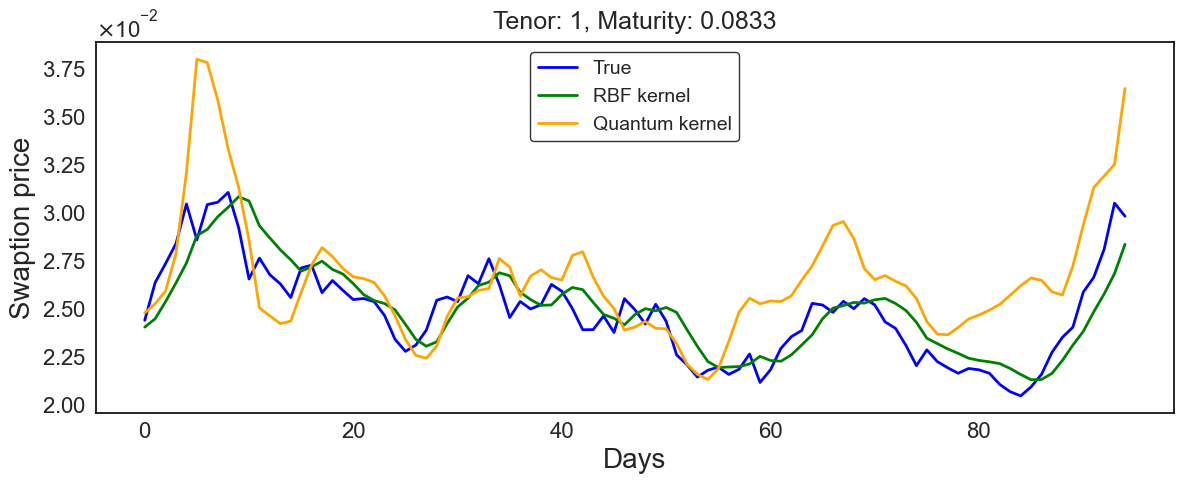

In [25]:
# === グラフ描画 ===
plt.figure(figsize=(12, 5), facecolor='white')

# 実測・予測のプロット
plt.plot(y_test_inv, label="True", color="b", linewidth=2)
plt.plot(y_pred_inv_rbf, label="RBF kernel", linestyle="-", color="g", linewidth=2)
plt.plot(y_pred_inv_qk, label="Quantum kernel", linestyle="-", color="orange", linewidth=2)

# === 枠・軸設定 ===
ax = plt.gca()
for spine in ax.spines.values():
    spine.set_edgecolor('black')
    spine.set_linewidth(1.2)

# === y軸を ×10^-2 表記に ===
formatter = ticker.ScalarFormatter(useMathText=True)
formatter.set_powerlimits((-2, -2))  # 強制的に ×10^-2 にする
ax.yaxis.set_major_formatter(formatter)
ax.ticklabel_format(style='sci', axis='y', scilimits=(-2, -2))

# === 軸ラベル・目盛りフォントサイズ ===
ax.tick_params(axis='x', labelsize=16)  # x軸目盛り
ax.tick_params(axis='y', labelsize=16)  # y軸目盛り

# ×10^-2 のサイズを大きくする
ax.yaxis.get_offset_text().set_size(16)

# === グラフ装飾 ===
plt.grid(False)
plt.legend(frameon=True, edgecolor="black", loc="best", fontsize=14)
plt.xlabel("Days", fontsize=20)
plt.ylabel("Swaption price", fontsize=20)
plt.title("Tenor: 1, Maturity: 0.0833", fontsize=18, pad=10)

# 余白調整
plt.tight_layout()
plt.show()


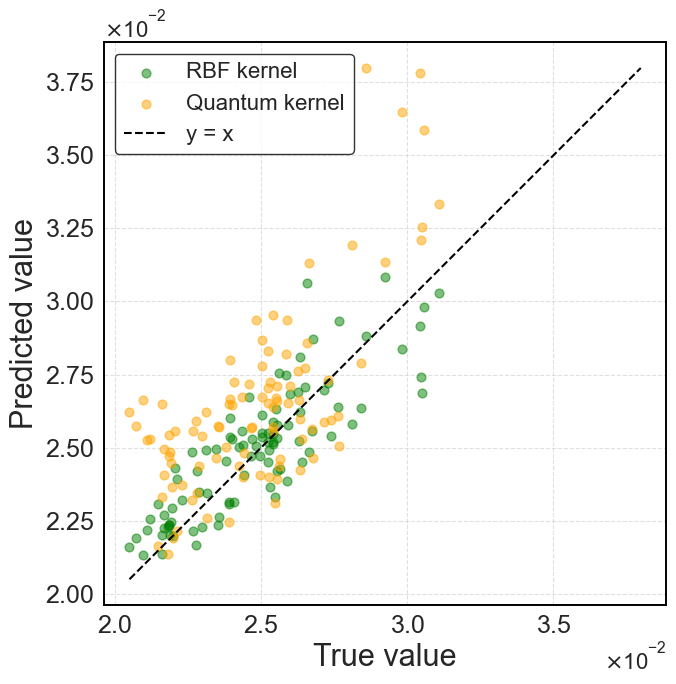

In [29]:
# === 図の設定 ===
plt.figure(figsize=(7, 7), facecolor='white')

# === yyプロット ===
plt.scatter(y_test_inv, y_pred_inv_rbf, color="g", alpha=0.5, s=40, label="RBF kernel")
plt.scatter(y_test_inv, y_pred_inv_qk, color="orange", alpha=0.5, s=40, label="Quantum kernel")

# === y=x の基準線 ===
min_val = min(np.min(y_test_inv), np.min(y_pred_inv_rbf), np.min(y_pred_inv_qk))
max_val = max(np.max(y_test_inv), np.max(y_pred_inv_rbf), np.max(y_pred_inv_qk))
plt.plot([min_val, max_val], [min_val, max_val], "k--", linewidth=1.5, label="y = x")

# === 軸・枠設定 ===
ax = plt.gca()
for spine in ax.spines.values():
    spine.set_edgecolor('black')
    spine.set_linewidth(1.4)

# === 軸を科学的記法（×10⁻²）に統一 ===
formatter = ticker.ScalarFormatter(useMathText=True)
formatter.set_powerlimits((-2, -2))
ax.xaxis.set_major_formatter(formatter)
ax.yaxis.set_major_formatter(formatter)
ax.ticklabel_format(style='sci', axis='both', scilimits=(-2, -2))

# === 軸ラベル・タイトル ===
plt.xlabel("True value", fontsize=22)
plt.ylabel("Predicted value", fontsize=22)
# plt.title("Comparison of RBF and Quantum Kernels", fontsize=22, pad=12)

# === 凡例とグリッド ===
plt.legend(frameon=True, edgecolor="black", fontsize=16, loc="best")
plt.grid(True, linestyle="--", alpha=0.6)

# === 軸文字サイズ・×10⁻²表記サイズ ===
ax.tick_params(axis='both', labelsize=18)
ax.xaxis.get_offset_text().set_fontsize(16)
ax.yaxis.get_offset_text().set_fontsize(16)

# === 正方形プロットに ===
ax.set_aspect('equal', adjustable='box')

# === 余白調整 ===
plt.tight_layout()
plt.show()
